# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 11.01

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [4]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: дробное число - это вероятность принадлежности прогноза к положительному классу (1). В зависимости от порога мы делаем вывод о принадлежности прогноза к тому или иному классу, т.е переводим дробь в $\{0; 1\}$

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


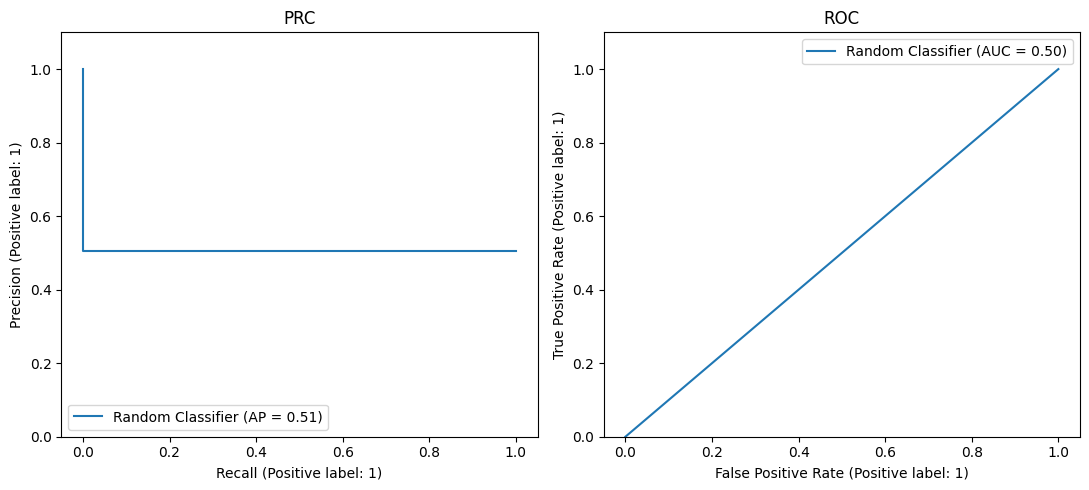

In [6]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [7]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [8]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
params_grid = {'C': np.logspace(-3, 2, 10)}
model = LinearSVC(max_iter = 1000000)
grid_search = GridSearchCV(estimator=model, param_grid=params_grid, cv=3, scoring='average_precision', verbose = 1)
grid_search.fit(X_train, y_train)
print(f'best params: {grid_search.best_params_}, best AUC-PR: {grid_search.best_score_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
best params: {'C': 0.5994842503189409}, best AUC-PR: 0.822656787450725


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

Linear SVC metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476


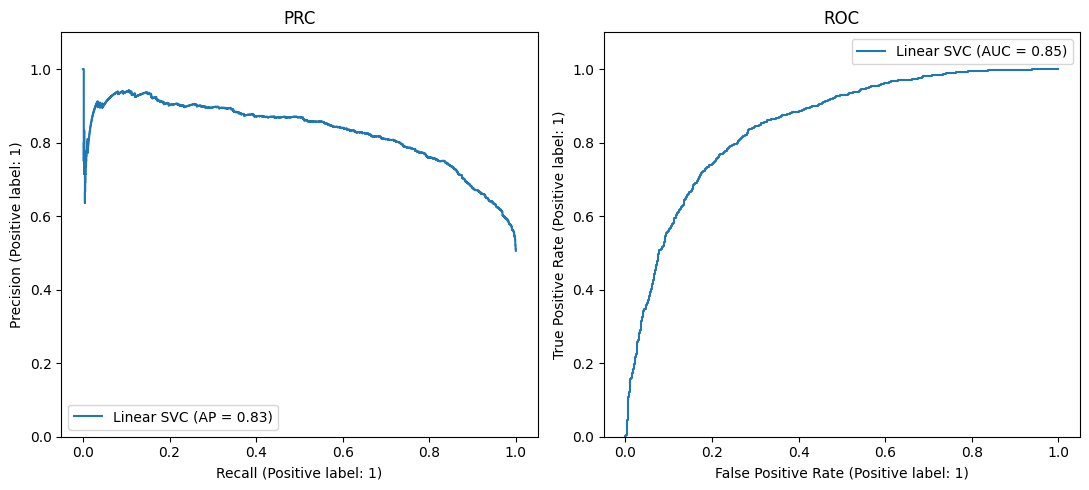

In [9]:
SVC = LinearSVC(max_iter = 1000000, C = grid_search.best_params_['C'])
SVC.fit(X_train, y_train)
y_pred_svc = SVC.decision_function(X_test)
depict_pr_roc(y_test, y_pred_svc, 'Linear SVC')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?

При увеличении порога мы меньше объектов относим к классу 1, а значит растет precision, а recall падает, так как становится меньше True Positive. Значит мы двигаемся по PRC справо налево, и увеличивается precision.

Для ROC TPR уменьшается, так как модель пропускает больше положительных примеров, и FPR тоже уменьшается, так как модель реже ошибочно классифицирует отрицательные примеры как положительные. Как итог, чем выше порог, тем ниже обе метрики, а значит мы двигаемся по кривой сверху вниз.

- Монотонные ли кривые? Как вы это объясните?

PRC не является монотонно убывающей. Recall всегда либо увеличивается, либо остается неизменным при снижении порога классификации, потому что больше объектов классифицируется как положительные, а precision может меняться в обоих направлениях, так как при снижении порога меняется и числитель, и знаменатель, и если объект, добавившийся к положительному прогнозу, будет TP, то precision растет, если будет FP, то снизится. А значит кривая может как расти, так и убывать, а значит она немонотонная.

Кривая ROC всегда монотонно возрастает, поскольку TPR и FPR либо остаются неизменными, либо уменьшаются с увеличением порога (объяснение выше!)

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


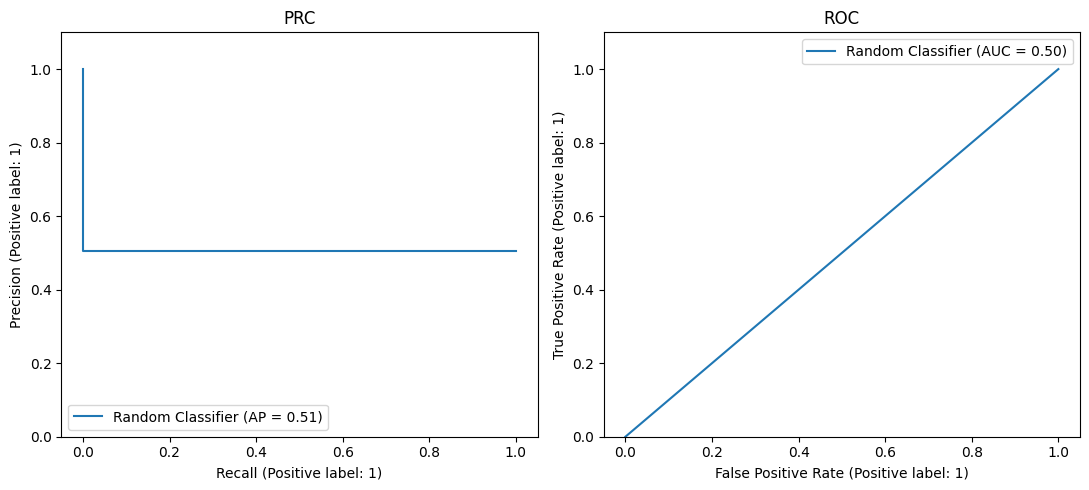

In [10]:
y_random = random_classifier.predict_proba(X_test)[:,1]
depict_pr_roc(y_test, y_random, 'Random Classifier')

Обе метрики у SVM лучше, чем у рандома, что более чем логично

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [11]:
from sklearn.linear_model import LogisticRegression
params_grid = {'C': np.logspace(-3, 2, 10)}
model = LogisticRegression(penalty='l2')
grid_search = GridSearchCV(estimator=model, param_grid=params_grid, cv=5, scoring='average_precision', verbose = 3)
grid_search.fit(X_train, y_train)
print(f'best params: {grid_search.best_params_}, best AUC-PR: {grid_search.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...........................C=0.001;, score=0.827 total time=   0.2s
[CV 2/5] END ...........................C=0.001;, score=0.816 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.844 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.820 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.832 total time=   0.0s
[CV 1/5] END ............C=0.003593813663804626;, score=0.825 total time=   0.0s
[CV 2/5] END ............C=0.003593813663804626;, score=0.815 total time=   0.0s
[CV 3/5] END ............C=0.003593813663804626;, score=0.840 total time=   0.0s
[CV 4/5] END ............C=0.003593813663804626;, score=0.816 total time=   0.0s
[CV 5/5] END ............C=0.003593813663804626;, score=0.828 total time=   0.0s
[CV 1/5] END .............C=0.01291549665014884;, score=0.824 total time=   0.0s
[CV 2/5] END .............C=0.01291549665014884;

In [12]:
LR = LogisticRegression(penalty = 'l2', C = grid_search.best_params_['C'])
LR.fit(X_train, y_train)
y_pred_lr = LR.decision_function(X_test)

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Linear SVC metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476
Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
Logistic Regression metrics
AUC-PR: 0.8338
AUC-ROC: 0.8453


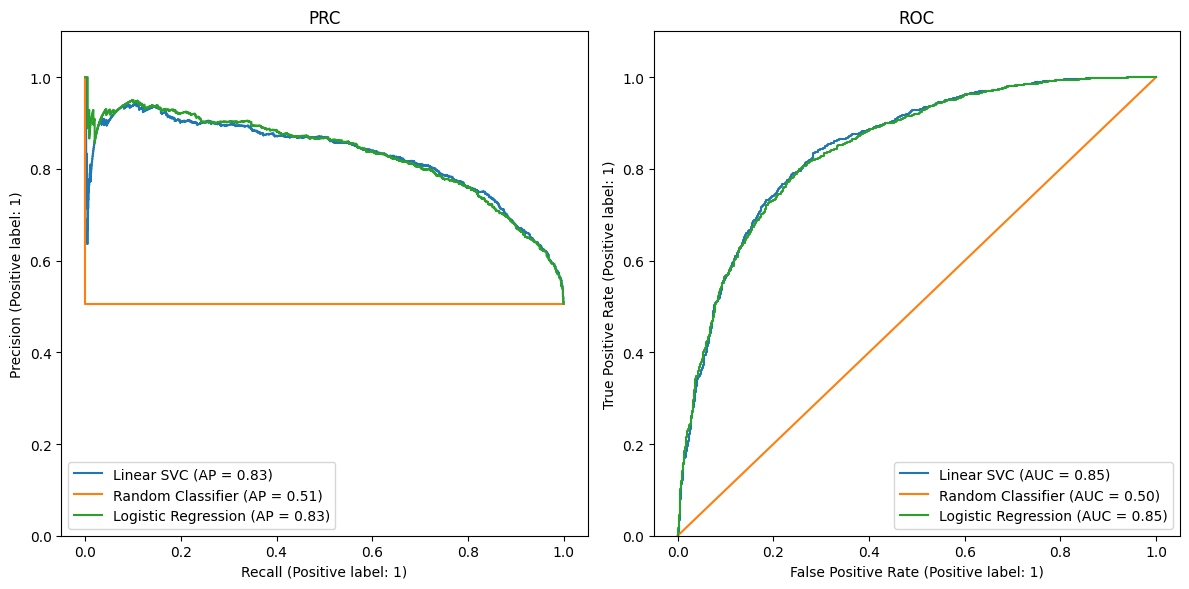

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
depict_pr_roc(y_test, y_pred_svc, 'Linear SVC', ax)
depict_pr_roc(y_test, y_random, 'Random Classifier', ax)
depict_pr_roc(y_test, y_pred_lr, 'Logistic Regression', ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Показатели обеих моделей почти одинаковые, однако SVM обучается сильно дольше, особенно на больших C

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [14]:
from sklearn.svm import SVC
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant = 0, random_state=42)
model = SVC(kernel = 'linear')
model.fit(X, y)

SVC(kernel='linear')

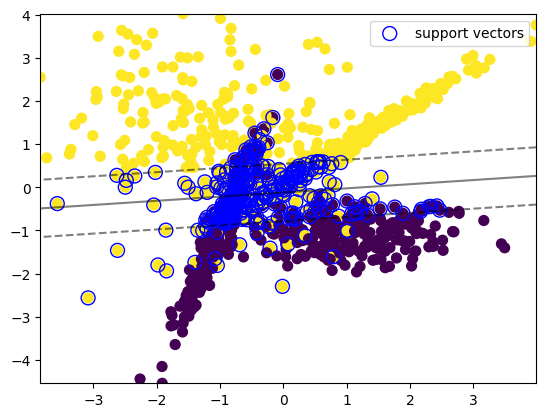

In [15]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c = y, s = 50
                )

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    label='support vectors',
                    s=100,
                    linewidth=1,
                    edgecolor="blue",
                    facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Опорными выделяются объекты, которые оказывают наиольнее влияние на определение гиперплоскости SVM. Они находятся в другом классе и находятся на или за границей

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [16]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = 'l2')
model.fit(X, y)

LogisticRegression()

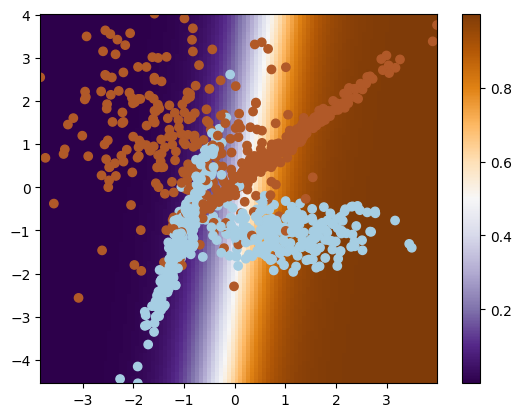

In [17]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1].reshape((xx.shape[0], -1)).T
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Это белая область - здесь "расстояние" до обоих классов у модели одинаковое и она не уверена, к какому классу ближе можно отнести предсказание

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [18]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot([0, 1], [0, 1], 'k--', label='Ideal')
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [19]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

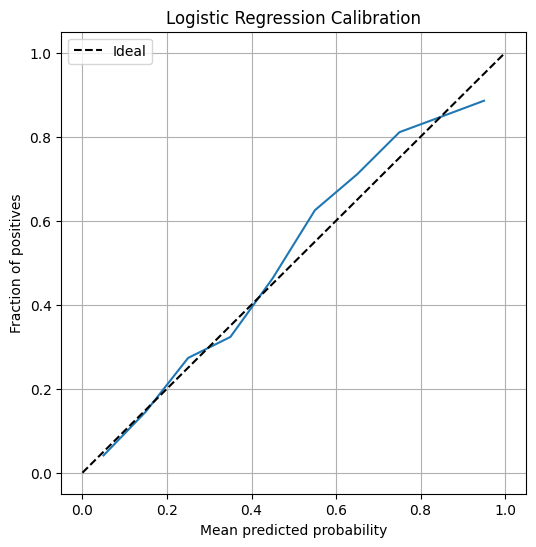

In [20]:
lr_model = LogisticRegression(penalty = 'l2')
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, lr_pred)
plt.title('Logistic Regression Calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.show()

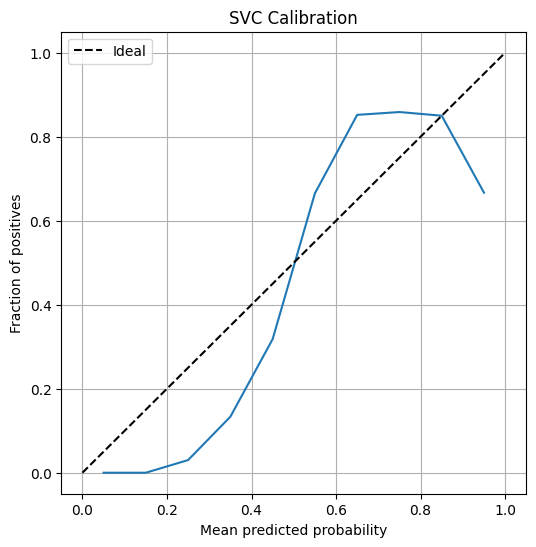

In [21]:
svc_model = SVC(kernel = 'linear', max_iter = 100000, C = 0.01)
svc_model.fit(X_train, y_train)
svc_pred = svc_model.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
plot_calibration_curve(y_test, svc_pred)
plt.title('SVC Calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** для логистической регрессии довольно неплохо откалиброваны, для SVM хуже, так как график SVM значительно отличается от иделальной кривой, в отличие от логистической регрессии.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [22]:
from sklearn.metrics import log_loss, brier_score_loss

logloss_lr = log_loss(y_test, lr_pred)
logloss_svm = log_loss(y_test, svc_pred)

brier_lr = brier_score_loss(y_test, lr_pred)
brier_svm = brier_score_loss(y_test, svc_pred)

print(f"LogLoss (Logistic Regression): {logloss_lr:.4f}")
print(f"LogLoss (SVC): {logloss_svm:.4f}")
print(f"Brier Score (Logistic Regression): {brier_lr:.4f}")
print(f"Brier Score (SVC): {brier_svm:.4f}")

LogLoss (Logistic Regression): 0.4852
LogLoss (SVC): 0.5694
Brier Score (Logistic Regression): 0.1573
Brier Score (SVC): 0.1832


Обе метрики хуже у SVC.

Изучите распределение ответов классификаторов при помощи гистограмм

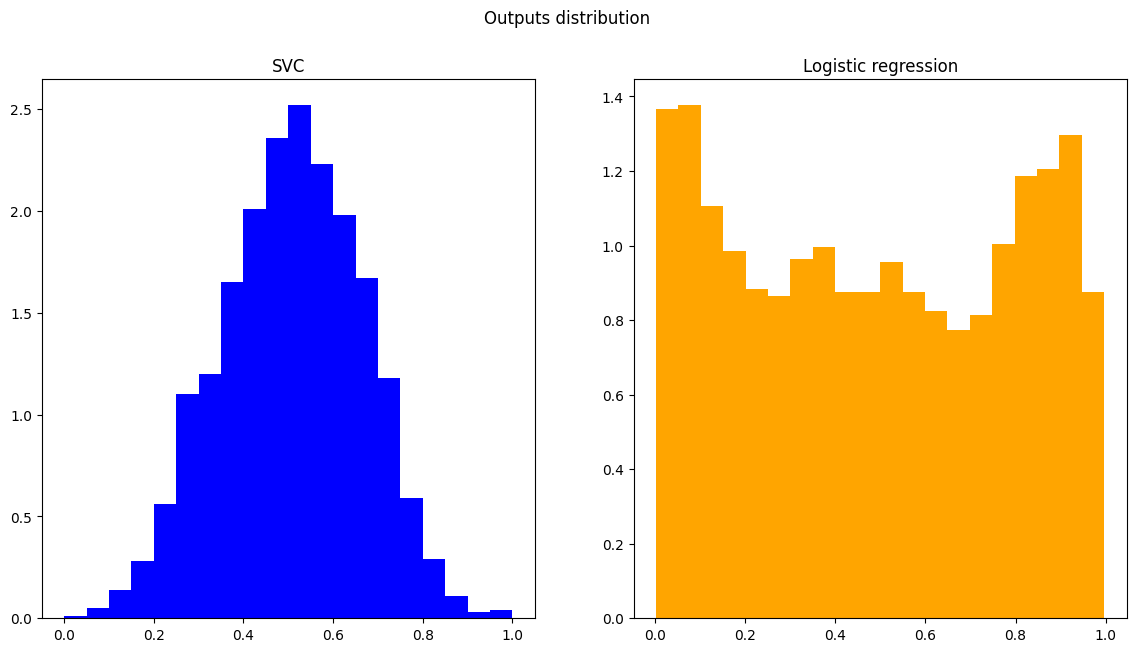

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Логистическая регрессия более уверена в своих результатах, т.к. наибольшая плотность - в концах, SVM же наоборот, в большинстве объектов не уверен, соответственно, такое и распределение

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

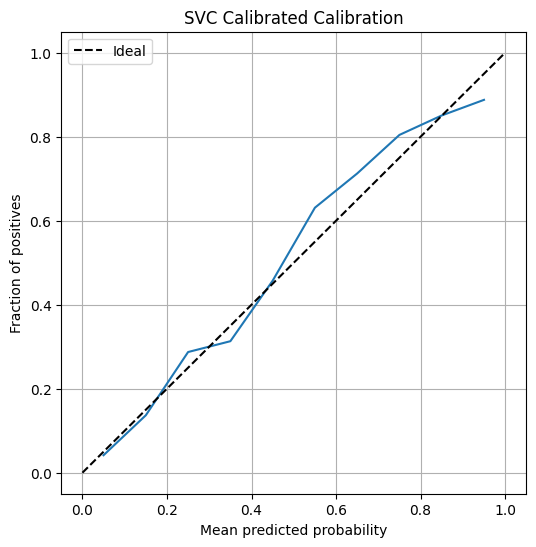

In [24]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
svc_calib = CalibratedClassifierCV(LinearSVC(max_iter=1000, C=0.1))
svc_calib.fit(X_train, y_train)
svc_calib_pred = svc_calib.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, svc_calib_pred)
plt.title('SVC Calibrated Calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:**  Да, улучшилась

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [25]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [26]:
df = pd.read_csv('bike_buyers.csv')

categorical_columns = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Purchased Bike']
df[categorical_columns] = df[categorical_columns].fillna('undefined')

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

X_numerical = X[['Income', 'Children', 'Cars', 'Age']]
X_categorical = X[['Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']]

В начале поработаем только с категориальными признаками

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [28]:
from sklearn.preprocessing import OrdinalEncoder
import time
from sklearn.linear_model import LogisticRegression

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

model = LogisticRegression()
start_time = time.time()
model.fit(X_train_encoded, y_train)
end_time = time.time()
training_time = end_time - start_time
y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score:", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.5728774226351424
Training Time: 0.007492780685424805 seconds


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [29]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

model = LogisticRegression(penalty = 'l2', C = 0.1)
start_time = time.time()
model.fit(X_train_encoded, y_train)
end_time = time.time()
training_time = end_time - start_time
y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score:", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.673386440793486
Training Time: 0.009853124618530273 seconds


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [31]:
start = time.time()
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()
for column in X_train.columns:
    column_dict = {}
    for category in X_train[column].unique():
        column_dict[category] = ((X_train[column] == category) & (y_train == 1)).sum() / ((X_train[column] == category).sum() + 1)
    X_train_encoded[column] = X_train[column].map(column_dict)
    X_test_encoded[column] = X_test[column].map(column_dict)
model = LogisticRegression(penalty = 'l2', C = 10**9)
model.fit(X_train_encoded, y_train)
end = time.time()
training_time = end_time - start_time
y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)
print("AUC-PR Score:", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.6940401186235012
Training Time: 0.009853124618530273 seconds


Score выше, чем у OHE

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
class MyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_code):
        self.columns_to_code = columns_to_code

    def fit(self, X, y):
        self.categoric_dict = dict()
        for column in self.columns_to_code:
            column_dict = dict()
            for category in  pd.unique(X[column]):
                column_dict[category] = ((X[column] == category) & (y == 1)).sum() / ((X[column] == category).sum())
            self.categoric_dict[column] = column_dict
        return self

    def transform(self, X):
        for column in self.columns_to_code:
            X[column] = X[column].apply(lambda x: self.categoric_dict[column].get(x, 0))
        return X

In [33]:
start_time = time.time()

my_encoder = MyEncoder(X_train.columns)
my_encoder.fit(X_train, y_train)

X_train_encoded = my_encoder.transform(X_train)
X_test_encoded = my_encoder.transform(X_test)
model = LogisticRegression()
model.fit(X_train_encoded, y_train)
end_time = time.time()
training_time = end_time - start_time
y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score:", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.6760358202625318
Training Time: 0.03351426124572754 seconds


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
class EncoderNoise(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_code, noise):
        self.columns_to_code = columns_to_code
        self.noise = noise
    def fit(self, X, y):
        self.categoric_dict = dict()
        for column in self.columns_to_code:
            column_dict = dict()
            for category in  pd.unique(X[column]):
                column_dict[category] = ((X[column] == category) & (y == 1)).sum() / ((X[column] == category).sum()) + np.random.randn() * self.noise
            self.categoric_dict[column] = column_dict
        return self

    def transform(self, X):
        for column in self.columns_to_code:
            X[column] = X[column].apply(lambda x: self.categoric_dict[column].get(x, 0))
        return X

In [35]:
np.random.seed(42)
start_time = time.time()

my_encoder = EncoderNoise(X_train.columns, 1e-2)
my_encoder.fit(X_train, y_train)

X_train_encoded = my_encoder.transform(X_train)
X_test_encoded = my_encoder.transform(X_test)
model = LogisticRegression()
model.fit(X_train_encoded, y_train)
end_time = time.time()
training_time = end_time - start_time
y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score:", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.6803844666284244
Training Time: 0.03225302696228027 seconds


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шума улчшило метрику, потому что он помогает бороться с обучением, обобщая предсказания модели, не давая ей сильно подогнаться под данные

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [36]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

 Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.


Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
class MyEncoderNoiseVanilla(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_code, noise, C):
        self.columns_to_code = columns_to_code
        self.noise = noise
        self.C = C
    def fit(self, X, y):
        self.categoric_dict = dict()
        for column in self.columns_to_code:
            column_dict = dict()
            for category in  pd.unique(X[column]):
                column_dict[category] = (((X[column] == category) & (y == 1)).sum() + C * np.mean(y)) / ((X[column] == category).sum() + C) + np.random.randn() * self.noise
            self.categoric_dict[column] = column_dict
        return self

    def transform(self, X):
        for column in self.columns_to_code:
            X[column] = X[column].apply(lambda x: self.categoric_dict[column].get(x, 0))
        return X

np.random.seed(42)
start_time = time.time()
best_score = -1
best_C = None
for C in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
    my_encoder = MyEncoderNoiseVanilla(X_train.columns, 1e-2, C)
    my_encoder.fit(X_train, y_train)

    X_train_encoded = my_encoder.transform(X_train)
    X_test_encoded = my_encoder.transform(X_test)
    model = LogisticRegression()
    model.fit(X_train_encoded, y_train)
    y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    score = auc(recall, precision)

    if score > best_score:
        best_score = score
        best_C = C
end_time = time.time()
training_time = end_time - start_time

print(f"AUC-PR Score: { best_score}, Best C: {best_C}")
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.683725395058496, Best C: 20
Training Time: 0.19865107536315918 seconds


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [38]:
X_numerical = X[['Income', 'Children', 'Cars', 'Age']]
X_numerical.isna().sum()

Income      6
Children    8
Cars        9
Age         8
dtype: int64

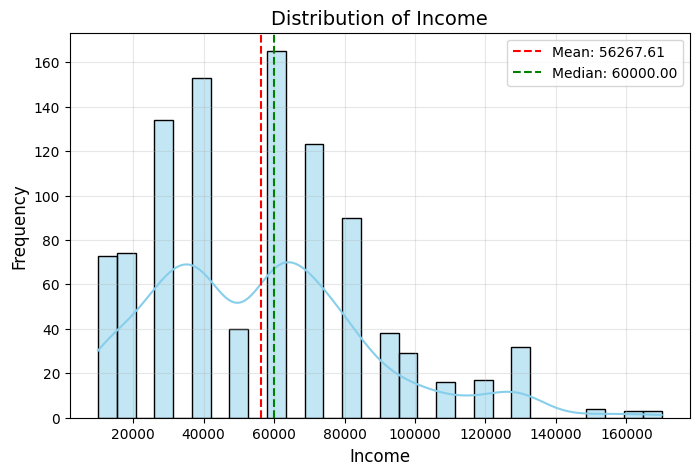

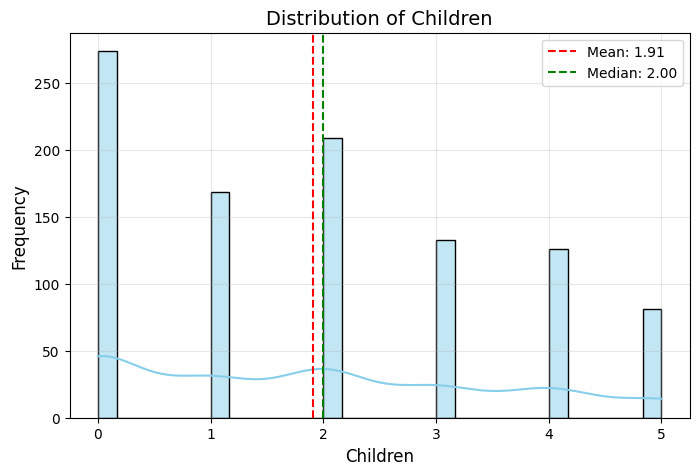

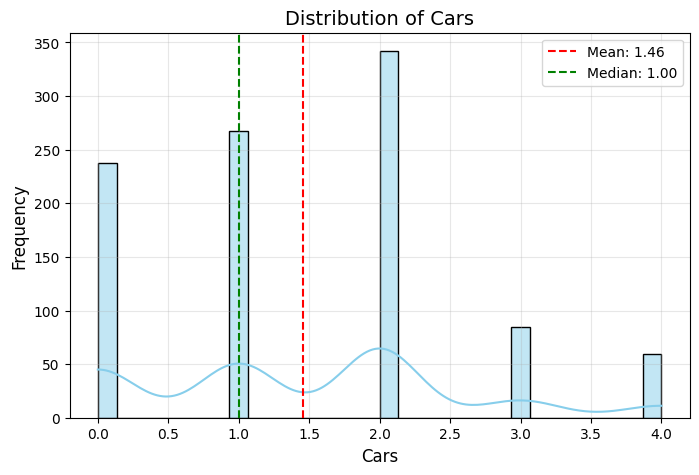

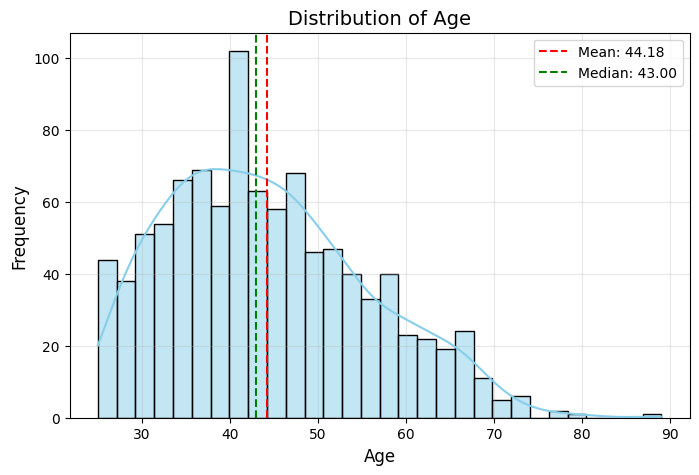

In [39]:
import seaborn as sns

for col in X_numerical.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(X_numerical[col], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.axvline(X_numerical[col].mean(), color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {X_numerical[col].mean():.2f}')
    plt.axvline(X_numerical[col].median(), color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {X_numerical[col].median():.2f}')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

Заменяю на медиану, так как здесь у части переменных мало уникальных значений, а у других - ассиметричное распределение, поэтому правильнее заменить на медиану.

In [40]:
for column in X_numerical.columns:
    X_numerical[column].fillna(X_numerical[column].median(), inplace=True)

In [41]:
X_numerical.isna().sum()

Income      0
Children    0
Cars        0
Age         0
dtype: int64

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

Income и Age содержат в себе много значение: 16 и 53. Поэтому для них OHE было бы не очень делать

In [42]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

start_time = time.time()
best_score = -1
best_C = None

for C in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
    my_encoder = MyEncoderNoiseVanilla(X_train.columns, 1e-2, C)
    my_encoder.fit(X_train, y_train)

    X_train_encoded = my_encoder.transform(X_train)
    X_test_encoded = my_encoder.transform(X_test)
    model = LogisticRegression()
    model.fit(X_train_encoded, y_train)
    y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    score = auc(recall, precision)

    if score > best_score:
        best_score = score
        best_C = C
end_time = time.time()
training_time = end_time - start_time

print(f"AUC-PR Score: { best_score}, Best C: {best_C}")
print("Training Time:", training_time, "seconds")

AUC-PR Score: 0.7039959174212351, Best C: 50
Training Time: 2.464205026626587 seconds


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

Плюсы:

- OНЕ слаб, когда данные разрежены, то есть когда у нас признаку соответствует мало значений (мало единичек в столбце).

- Cчетчики более скореллированы с таргетом, OHE же никак не связан

Минусы:

- Реализация счётчиков требует дополнительных расчётов.

- Дольше обучается.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [43]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
4538,20,Private,70240,HS-grad,9,Never-married,Sales,Own-child,Asian-Pac-Islander,Female,0,0,24,Philippines,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [44]:
X = df.drop(columns='income')
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25, stratify=df['income'], random_state=777)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [45]:
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()
X_train_encoded.shape[1] - X[categorical_features].shape[1]

94

In [46]:
X_train = X_train[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_train_encoded))
X_test = X_test[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_test_encoded))

In [47]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

In [49]:
model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 10)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score:", score)

AUC-PR Score: 0.45033186144158865


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [50]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

X_train_sub.columns = X_train_sub.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

Важно: в 9-10 пунктах, где не нужна валидационная выборка, я буду обучать на train (не train_sub, то есть на 3/4 от выборки), а проверять на test, чтобы можно было честно сравнивать с изначальным результатом. И вообще, я каждый раз все заново скалирую/кодию, так что я в 11 номере еще раз сделаю сплит

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [51]:
import time
start_time = time.time()

X_train_40bestfeatures = X_train.iloc[:, model.coef_[0].argsort()[-40:]]
X_test_40bestfeatures = X_test.iloc[:, model.coef_[0].argsort()[-40:]]

model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 10)
model.fit(X_train_40bestfeatures, y_train)
y_pred_prob = model.predict_proba(X_test_40bestfeatures)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

end_time = time.time()
training_time = end_time - start_time

print("AUC-PR Score", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score 0.7371905839759831
Training Time: 0.443666934967041 seconds


Изменилось ли качество? Как?

Качество ухудшилось на 15 тысячных, однако мы убрали 62 признака, так что это шаг в правильную сторону.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25, stratify=df['income'], random_state=777)

X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_features]).toarray())
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_features]).toarray())
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric_features]))
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_features]))
X_train_scaled.columns = numeric_features
X_test_scaled.columns = numeric_features

X_train = X_train_scaled.join(X_train_encoded)
X_test = X_test_scaled.join(X_test_encoded)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 0.1)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

print("AUC-PR Score", score)

AUC-PR Score 0.7675450591382512


Качество выросло на 1 тысячных относительно того, что было без scaler.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [53]:
import time
start_time = time.time()

X_train_40bestfeatures_1 = X_train.iloc[:, model.coef_[0].argsort()[-40:]]
X_test_40bestfeatures_1 = X_test.iloc[:, model.coef_[0].argsort()[-40:]]

model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 0.1)
model.fit(X_train_40bestfeatures_1, y_train)
y_pred_prob = model.predict_proba(X_test_40bestfeatures_1)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

end_time = time.time()
training_time = end_time - start_time

print("AUC-PR Score", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score 0.76450094257311
Training Time: 0.22290492057800293 seconds


Качество упало всего лишь на 3 тысячных, и стало почти как качество без скалера и с 102 признаками. Получается, мы убрали 62 признака, а качество почти не потеряли, и это очень хороший trade-off

In [54]:
X_test_40bestfeatures_1

,48,fnlwgt,33,47,21,96,35,4,84,65,57,69,12,61,5,70,54,19,23,capital-loss,99,13,44,82,age,hours-per-week,90,59,71,62,26,42,45,43,1,education-num,36,52,27,capital-gain
0,1.0,-1.515779,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.217048,1.0,0.0,0.0,0.0,1.059891,0.770117,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.414713,0.0,0.0,0.0,-0.146962
1,0.0,0.126005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.217048,1.0,0.0,0.0,0.0,-0.997258,0.365360,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.747518,0.0,0.0,0.0,-0.146962
2,0.0,2.021691,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.217048,1.0,0.0,0.0,0.0,0.839482,0.770117,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.414713,0.0,0.0,1.0,13.093499
3,0.0,-0.293286,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.217048,1.0,0.0,0.0,0.0,-0.556440,-1.091769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.414713,0.0,1.0,1.0,-0.146962
4,0.0,-1.204358,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.217048,1.0,0.0,0.0,0.0,-0.409501,-0.039398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.414713,0.0,0.0,0.0,-0.146962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,0.0,0.341428,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.217048,1.0,0.0,0.0,0.0,-0.629910,0.770117,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.414713,1.0,0.0,1.0,-0.146962
8137,1.0,0.663185,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.217048,1.0,0.0,0.0,0.0,-0.923788,2.793907,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.027303,0.0,0.0,0.0,0.140889
8138,1.0,0.138926,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.217048,0.0,0.0,0.0,0.0,-0.629910,0.770117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.134929,0.0,0.0,0.0,-0.146962
8139,0.0,2.373614,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.217048,1.0,0.0,0.0,0.0,-1.217667,-1.658430,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.027303,0.0,0.0,0.0,-0.146962


In [55]:
X_test_40bestfeatures

,94,98,76,3,75,97,78,77,34,80,82,101,61,63,69,84,45,62,96,26,71,70,90,65,79,43,1,59,19,23,5,52,21,42,18,36,capital-gain,47,27,capital-loss
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99999,1.0,1.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,1.0,0
8137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2174,0.0,0.0,0
8138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0
8139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0


Да, список индексов поменялся

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Корреляция между признаком и целевой переменной дает представление о линейной зависимости между ними. Чем выше по абсолютной величине корреляция, тем вероятнее, что признак содержит полезную информацию для предсказания целевой переменной.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [56]:
start_time = time.time()

correlations = X_train.corrwith(y_train)

top_features = correlations.abs().sort_values(ascending=False).head(40).index

X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

model = LogisticRegression(max_iter=10000, penalty='l2', C=0.1)
model.fit(X_train_selected, y_train)
y_pred_prob = model.predict_proba(X_test_selected)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)

end_time = time.time()
training_time = end_time - start_time

print("AUC-PR Score", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score 0.6482836230783583
Training Time: 0.41785597801208496 seconds


Качество сильно упало (0.64)

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25, stratify=df['income'], random_state=777)

X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()

X_train = X_train[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_train_encoded))
X_test = X_test[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_test_encoded))

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)
df_train = X_train.join(y_train)

In [58]:
start_time = time.time()
t_columns = {}

for column in df_train.columns:
    if column == 'income':
        continue
    mu_plus = np.mean(df_train[df_train['income'] == 1][column])
    mu_minus = np.mean(df_train[df_train['income'] == 0][column])
    std_plus = np.std(df_train[df_train['income'] == 1][column])
    std_minus = np.std(df_train[df_train['income'] == 0][column])
    n_plus =len(df_train[df_train['income'] == 1][column])
    n_minus= len(df_train[df_train['income'] == 0][column])
    if (n_plus * (std_plus ** 2) + n_minus * (std_minus ** 2)) / (n_plus + n_minus) == 0:
        continue
    t_column = np.abs(mu_plus - mu_minus) / ((n_plus * (std_plus ** 2) + n_minus * (std_minus ** 2)) / (n_plus + n_minus))
    t_columns[column] = t_column

t_columns_40bestfeatures = sorted(t_columns, key=t_columns.get)[-40:]
X_train_40bestfeatures = X_train[t_columns_40bestfeatures]
X_test_40bestfeatures = X_test[t_columns_40bestfeatures]
end_time = time.time()

model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 10)
model.fit(X_train_40bestfeatures, y_train)
y_pred_prob = model.predict_proba(X_test_40bestfeatures)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)
training_time = end_time - start_time

print("AUC-PR Score", score)
print("Training Time:", training_time, "seconds")

AUC-PR Score 0.42796058791428604
Training Time: 1.0169670581817627 seconds


Времени занимает больше, чем другие методы, хотя всего 100 признаков, а качество низкое (0.42)

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [59]:
from tqdm.notebook import tqdm

X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25, stratify=df['income'], random_state=777)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=777)
X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_val_encoded = encoder.transform(X_val[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()
X_train = X_train[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_train_encoded))
X_val = X_val[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_val_encoded))
X_test = X_test[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_test_encoded))
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

start_time = time.time()
encoder = OneHotEncoder()
model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 0.1)

progress_bar = tqdm(range(len(X_train.columns), 39, -1))
while len(X_train.columns) > 40:
    progress_bar.set_description(f"Current number of columns: {len(X_train.columns)}")

    worst_score = 2
    worst_column = None

    for column in X_train.columns:
        X_train_drop_feature = X_train.drop(column, axis = 1)
        X_val_drop_feature = X_val.drop(column, axis = 1)
        model.fit(X_train_drop_feature, y_train)
        y_pred_prob = model.predict_proba(X_val_drop_feature)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
        score = auc(recall, precision)

        if score < worst_score:
            worst_score = score
            worst_column = column

    X_train = X_train.drop(worst_column, axis = 1)
    X_val = X_val.drop(worst_column, axis = 1)

progress_bar.set_description(f"Current number of columns: {len(X_train.columns)}")
progress_bar.close()
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

  0%|          | 0/69 [00:00<?, ?it/s]

Training Time: 178.178297996521 seconds


In [60]:
X_test = X_test[X_train.columns]
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)
print("AUC-PR Score", max(score, 1 - score))

AUC-PR Score 0.7571928256174717


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [61]:
from tqdm.notebook import tqdm

X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25, stratify=df['income'], random_state=777)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=777)

X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_val_encoded = encoder.transform(X_val[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()

X_train = X_train[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_train_encoded))
X_val = X_val[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_val_encoded))
X_test = X_test[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_test_encoded))

X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

X_train_1 = X_train.copy()

start_time = time.time()
encoder = OneHotEncoder()
model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 0.1)
best_columns = []

progress_bar = tqdm(range(0, 40, 1))
while len(best_columns) < 40:
    progress_bar.set_description(f"Current number of columns: {len(best_columns)}")

    best_score = -1
    best_column = None

    for column in X_train.columns:
        model.fit(np.array([X_train[column]]).T, y_train)
        y_pred_prob = model.predict_proba(np.array([X_val[column]]).T)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
        score = auc(recall, precision)

        if score > best_score:
            best_score = score
            best_column = column

    best_columns.append(best_column)
    X_train = X_train.drop(best_column, axis = 1)
progress_bar.set_description(f"Current number of columns: {len(best_columns)}")
progress_bar.close()
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

  0%|          | 0/40 [00:00<?, ?it/s]

Training Time: 32.401358127593994 seconds


In [62]:
X_train_1 = X_train_1[best_columns]
X_val = X_val[best_columns]
X_test = X_test[best_columns]
model.fit(X_train_1, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
score = auc(recall, precision)
print("AUC-PR Score", max(score, 1 - score))

AUC-PR Score 0.6601079200062848


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**  Получилось, что простой выбор 40 фичей с самыми большими весами показал лучший результат. 

Методы с перебором всех фичей работают хуже, чем простой выбор фичей, контринтуитивны и бесконечно долго обучаются. 

Я не очень понимаю, как метод фильтрации не обошел все остальные методы, потому что казался самым логичным, однако хочется сказать, что условный permutation score в случае оценки регрессии был бы лучшим индикатором оценки важности фичей.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [63]:
import requests
import zipfile
import os

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
zip_path = "bank-additional.zip"

response = requests.get(url)
with open(zip_path, "wb") as file:
    file.write(response.content)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("bank-additional")

df = pd.read_csv("bank-additional/bank-additional-full.csv", sep=";")

In [64]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [65]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

**Ответ**: Я выбрал recall, так как мы хотим привлечь как можно больше клиентов, которые готовы открыть депозит, при этом наши потери от лишнего звонка незначительны

In [66]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score

categ_columns = list(X.select_dtypes(include='object').columns)
num_columns = list(X.select_dtypes(exclude='object').columns)
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(), categ_columns),
        ('numeric', StandardScaler(), num_columns)
    ])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=52)
X_transformed = pipeline.fit_transform(X)
model = LogisticRegression()
ps = []
tcs = []
trs = []
recalls = [] 
for train_index, test_index in kf.split(X_transformed, y):
    X_transformed = pd.DataFrame(X_transformed)
    X_train, X_test = X_transformed.iloc[train_index], X_transformed.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_calls = model.predict_proba(X_test)[:, 1]
    y_calls = (y_calls > 0.5).astype(int)
    TR = 10 * y_calls[(y_calls == y_test.to_list())&(y_calls == 1)].sum()
    TC = 2 * y_calls.sum()
    profit = TR - TC
    recall = recall_score(y_test, y_calls)
    tcs.append(TC)
    trs.append(TR)
    ps.append(profit)
    recalls.append(recall)

Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [67]:
print('Average Earnings:', np.mean(ps))
print('Standard Deviation of Profits:', np.std(ps))
print('Average Costs:', np.mean(tcs))
print('Average Recall', np.mean(recalls))

Average Earnings: 1474.4
Standard Deviation of Profits: 83.73673029202895
Average Costs: 639.6
Average Recall 0.22799576916075245


Recall и прибыль имеют положительную связь, так как чем больше TP и меньше FN, тем большему нужных клиентов позвонят, тем больше заработает банк. Выручка вырастет, прибыль тоже, так как при увеличении звонков на 1, мы тратим 2, но от положительного зарабатываем 10.

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [68]:
ps = []
tcs = []
trs = []
recalls = [] 

import random
for train_index, test_index in kf.split(X_transformed, y):
    X_transformed = pd.DataFrame(X_transformed)
    X_train, X_test = X_transformed.iloc[train_index], X_transformed.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_calls = model.predict_proba(X_test)[:, 1]
    y_calls = (y_calls > 0.5).astype(int)
    y_train = y_train.to_list()
    TR = sum(random.uniform(0, 20) for i in range(len(y_calls)) if y_calls[i] == y_test.iloc[i] and y_calls[i] == 1)
    recall = recall_score(y_test, y_calls)
    TC = 2 * y_calls.sum()
    profit = TR - TC
    tcs.append(TC)
    trs.append(TR)
    ps.append(profit)
    recalls.append(recall)

In [69]:
print('Average Earnings:', np.mean(ps))
print('Standard Deviation of Profits:', np.std(ps))
print('Average Costs:', np.mean(tcs))
print('Average Recall', np.mean(recalls))

Average Earnings: 1402.6332470935704
Standard Deviation of Profits: 121.42289057918634
Average Costs: 639.6
Average Recall 0.22799576916075245


Средняя прибыль выросла на 20 долларов, а стандартное отклонение выросло в 1,5 раза. Логично, так как больше разброс и больше неопределенности

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

Лучший C: 10.0
Средняя прибыль: 1482.61
Стандартное отклонение прибыли: 122.47
Recall: 0.22908150623054951


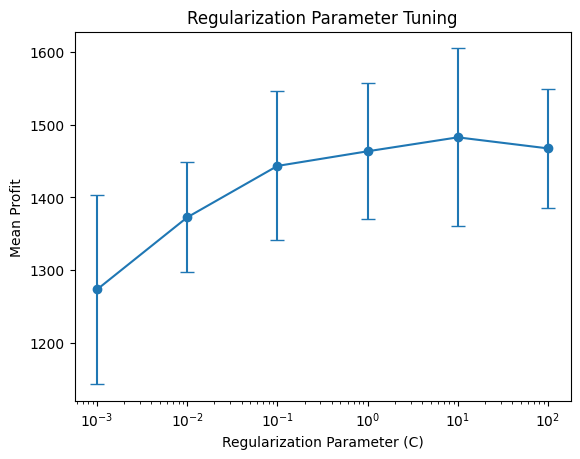

In [70]:
results = {'C': [], 'mean_profit': [], 'std_profit': [], 'recall': []}
C = np.logspace(-3, 2, num=6)

kf = KFold(n_splits=5, shuffle=True, random_state=52)

for hyper in C:
    profits = []
    recalls = []
    model = LogisticRegression(C=hyper)
    
    for train_index, test_index in kf.split(X_transformed, y):
        X_transformed = pd.DataFrame(X_transformed)
        X_train, X_test = X_transformed.iloc[train_index], X_transformed.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_calls = model.predict_proba(X_test)[:, 1]
        y_calls = (y_calls > 0.5).astype(int)
        y_train = y_train.to_list()
        TR = sum(random.uniform(0, 20) for i in range(len(y_calls)) if y_calls[i] == y_test.iloc[i] and y_calls[i] == 1)
        TC = 2 * y_calls.sum()
        profit = TR - TC
        profits.append(profit)
        recalls.append(recall_score(y_test, y_calls))
    
    results['C'].append(hyper)
    results['mean_profit'].append(np.mean(profits))
    results['std_profit'].append(np.std(profits))
    results['recall'].append(np.mean(recalls))

results_df = pd.DataFrame(results)

best_index = results_df['mean_profit'].idxmax()
best_C = results_df.loc[best_index, 'C']
best_mean_profit = results_df.loc[best_index, 'mean_profit']
best_std_profit = results_df.loc[best_index, 'std_profit']
best_recall = results_df.loc[best_index, 'recall']

print(f"Лучший C: {best_C}")
print(f"Средняя прибыль: {best_mean_profit:.2f}")
print(f"Стандартное отклонение прибыли: {best_std_profit:.2f}")
print(f"Recall: {best_recall}")

plt.errorbar(results_df['C'], results_df['mean_profit'], yerr=results_df['std_profit'], fmt='o-', capsize=5)
plt.xscale('log')  
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Mean Profit')
plt.title('Regularization Parameter Tuning')
plt.show()

Прибыль немного выросла, стандартное отклонение - снизилось, recall - вырос

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Лучший C: 10.0
Средняя прибыль: 1552.55
Стандартное отклонение прибыли: 87.70
Recall: 0.22908150623054951


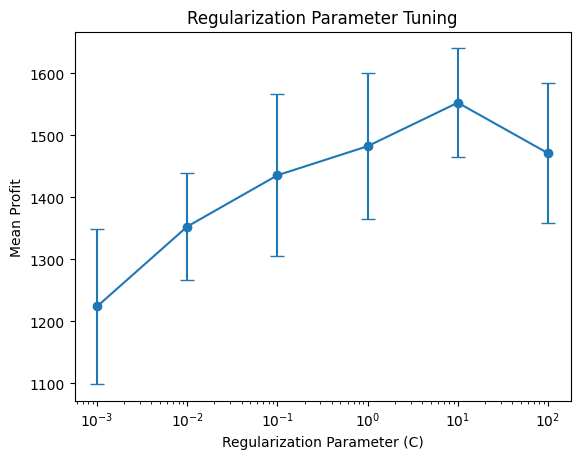

Лучший C: 0.1
Средняя прибыль: 1516.68
Стандартное отклонение прибыли: 87.27
Recall: 0.22467307784077062


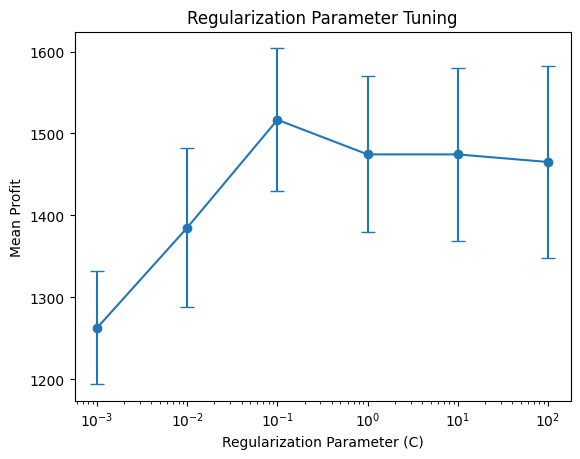

Лучший C: 100.0
Средняя прибыль: 1503.90
Стандартное отклонение прибыли: 114.16
Recall: 0.22908150623054951


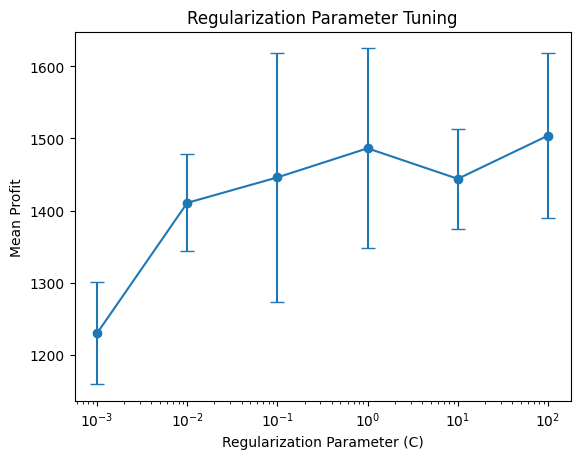

Лучший C: 100.0
Средняя прибыль: 1493.77
Стандартное отклонение прибыли: 103.87
Recall: 0.22908150623054951


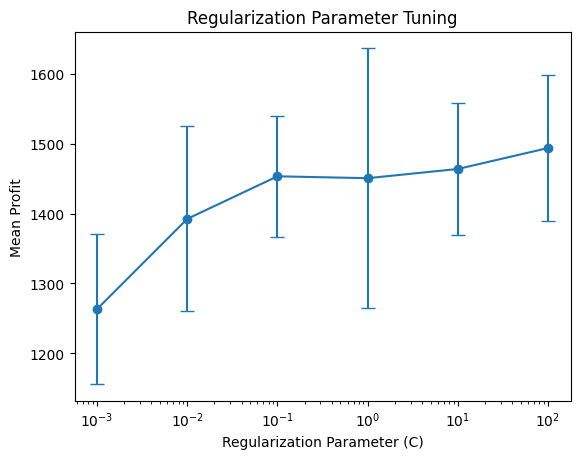

In [71]:
for mo in [1,2,3,4]:
    results = {'C': [], 'mean_profit': [], 'std_profit': [], 'recall': []}
    C = np.logspace(-3, 2, num=6)

    kf = KFold(n_splits=5, shuffle=True, random_state=52)

    for hyper in C:
        profits = []
        recalls = []
        model = LogisticRegression(C=hyper)

        for train_index, test_index in kf.split(X_transformed, y):
            X_transformed = pd.DataFrame(X_transformed)
            X_train, X_test = X_transformed.iloc[train_index], X_transformed.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model.fit(X_train, y_train)
            y_calls = model.predict_proba(X_test)[:, 1]
            y_calls = (y_calls > 0.5).astype(int)
            y_train = y_train.to_list()
            TR = sum(random.uniform(0, 20) for i in range(len(y_calls)) if y_calls[i] == y_test.iloc[i] and y_calls[i] == 1)
            TC = 2 * y_calls.sum()
            profit = TR - TC
            profits.append(profit)
            recalls.append(recall_score(y_test, y_calls))

        results['C'].append(hyper)
        results['mean_profit'].append(np.mean(profits))
        results['std_profit'].append(np.std(profits))
        results['recall'].append(np.mean(recalls))

    results_df = pd.DataFrame(results)

    best_index = results_df['mean_profit'].idxmax()
    best_C = results_df.loc[best_index, 'C']
    best_mean_profit = results_df.loc[best_index, 'mean_profit']
    best_std_profit = results_df.loc[best_index, 'std_profit']
    best_recall = results_df.loc[best_index, 'recall']

    print(f"Лучший C: {best_C}")
    print(f"Средняя прибыль: {best_mean_profit:.2f}")
    print(f"Стандартное отклонение прибыли: {best_std_profit:.2f}")
    print(f"Recall: {best_recall}")

    plt.errorbar(results_df['C'], results_df['mean_profit'], yerr=results_df['std_profit'], fmt='o-', capsize=5)
    plt.xscale('log')  
    plt.xlabel('Regularization Parameter (C)')
    plt.ylabel('Mean Profit')
    plt.title('Regularization Parameter Tuning')
    plt.show()

Прибыль стала немного выше на всех этапах, чем без регуляризации. Recall иногда выше, иногда ниже, зависит от C. А стандратное отклонение всегда ниже.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Так как мы хотим привлечь как можно больше клиентов, которые готовы открыть депозит, при этом наши потери от лишнего звонка незначительны, поэтому надо выбирать recall.

> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [72]:
max_profit = -1000
results = {}
best_step = 0
results['mean_profit'] = []
results['std_profit'] = []
for step in np.linspace(0,1,100):
    profits = []
    model = LogisticRegression(C = hyper)
    for train_index, test_index in kf.split(X_transformed, y):
        X_transformed = pd.DataFrame(X_transformed)
        X_train, X_test = X_transformed.iloc[train_index], X_transformed.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_calls = model.predict_proba(X_test)[:, 1]
        y_calls = (y_calls > step).astype(int)
        y_test = y_test.to_list()
        TR = 0
        for i in range(len(y_calls)):
            if y_calls[i] == y_test[i] and y_calls[i] == 1:
                TR += random.uniform(0, 20)
        TC = 2 * y_calls.sum()
        profit = TR - TC
        profits.append(profit)
    results['mean_profit'].append(np.mean(profits))
    results['std_profit'].append(np.std(profits))
    if np.mean(profits) > max_profit:
        best_step = step
        max_profit = np.mean(profits)

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




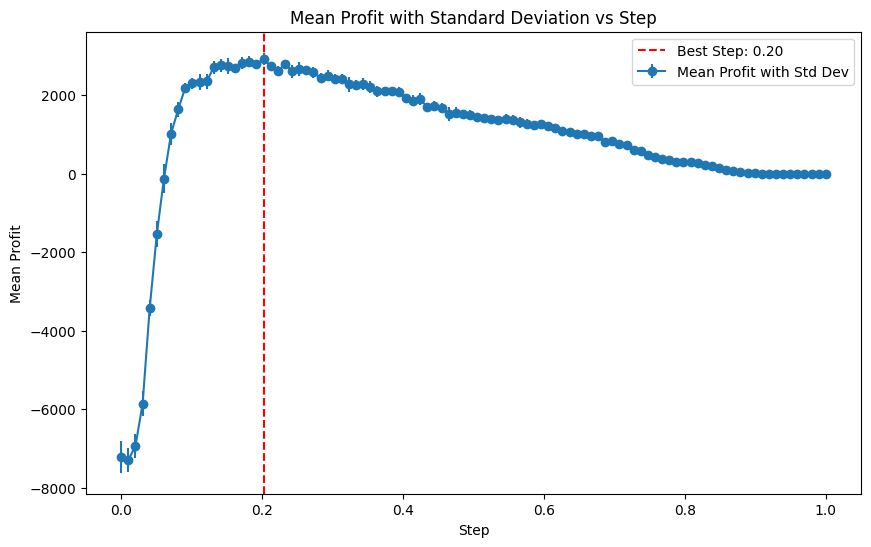

In [73]:
plt.figure(figsize=(10, 6))
plt.errorbar(np.linspace(0, 1, 100), results['mean_profit'], yerr=results['std_profit'], fmt='o-', label='Mean Profit with Std Dev')
plt.xlabel('Step')
plt.ylabel('Mean Profit')
plt.title('Mean Profit with Standard Deviation vs Step')
plt.axvline(x=best_step, color='r', linestyle='--', label=f'Best Step: {best_step:.2f}')
plt.legend()
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Закономерность очень прикольная. Cредний выигрыш равен 10, а средняя потеря равна 2, следовательно, нам надо выбрать вероятность того, что клиент сделает депозит на уровне 1/5 (0.2).

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [74]:
from sklearn.metrics import precision_score, recall_score
from scipy.stats import ttest_rel

optimized_profits = []
default_profits = []
optimized_precision_scores = []
optimized_recall_scores = []

for train_index, test_index in kf.split(X_transformed, y):
    X_transformed = pd.DataFrame(X_transformed)
    X_train, X_test = X_transformed.iloc[train_index], X_transformed.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    optimized_model = LogisticRegression(C=best_C)
    optimized_model.fit(X_train, y_train)
    y_calls_optimized = optimized_model.predict_proba(X_test)[:, 1]
    y_calls_optimized = (y_calls_optimized > best_step).astype(int)

    TR_optimized = sum(random.uniform(0, 20) for i in range(len(y_calls_optimized))
                       if y_calls_optimized[i] == y_test.iloc[i] and y_calls_optimized[i] == 1)
    TC_optimized = 2 * y_calls_optimized.sum()
    profit_optimized = TR_optimized - TC_optimized
    optimized_profits.append(profit_optimized)
    precision_optimized = precision_score(y_test, y_calls_optimized)
    recall_optimized = recall_score(y_test, y_calls_optimized)
    optimized_precision_scores.append(precision_optimized)
    optimized_recall_scores.append(recall_optimized)

    default_model = LogisticRegression()
    default_model.fit(X_train, y_train)
    y_calls_default = default_model.predict_proba(X_test)[:, 1]
    y_calls_default = (y_calls_default > 0.5).astype(int)

    TR_default = sum(random.uniform(0, 20) for i in range(len(y_calls_default))
                     if y_calls_default[i] == y_test.iloc[i] and y_calls_default[i] == 1)
    TC_default = 2 * y_calls_default.sum()
    profit_default = TR_default - TC_default
    default_profits.append(profit_default)

mean_optimized_precision = np.mean(optimized_precision_scores)
mean_optimized_recall = np.mean(optimized_recall_scores)
mean_optimized_profit = np.mean(optimized_profits)
std_optimized_profit = np.std(optimized_profits)
mean_default_profit = np.mean(default_profits)
std_default_profit = np.std(default_profits)

print(f"Итоговая модель: средняя прибыль = {mean_optimized_profit:.2f}, стандартное отклонение = {std_optimized_profit:.2f}")
print(f"Изначальная модель: средняя прибыль = {mean_default_profit:.2f}, стандартное отклонение = {std_default_profit:.2f}")

t_stat, p_value = ttest_rel(optimized_profits, default_profits)
alpha = 0.05
if p_value < alpha:
    print(f"Есть статистически значимые различия в прибыли (p = {p_value})")
else:
    print(f"Нет статистически значимых различий в прибыли (p = {p_value})")

Итоговая модель: средняя прибыль = 2736.65, стандартное отклонение = 207.91
Изначальная модель: средняя прибыль = 1432.34, стандартное отклонение = 82.39
Есть статистически значимые различия в прибыли (p = 8.971772180848666e-05)


In [75]:
print("Precision:", mean_optimized_precision)
print("Recall:", mean_optimized_recall)

Precision: 0.43070869054950445
Recall: 0.5632351871033026


# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Я позавтракал омлетом и творожками с чаем:)